In [1]:
import torch
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
from functions import *

In [2]:
# Window version
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# M1 MAC version
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(DEVICE)

mps


In [3]:
BATCH_SIZE = 32
LR = 1e-3
LR_STEP = 3
LR_GAMMA = 0.9
EPOCH = 15
train_ratio = 0.8
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = 'CNN_deep'
dataset = "STL10"
save_model_path = f'your path/result/{model_type}_{dataset}.pt'
save_history_path = f'your path/result/{model_type}_history_{dataset}.pt'

In [4]:
def to_uint8(x):
    return (255*x).type(torch.uint8)

In [5]:
transform_train = transforms.Compose([
    transforms.ToTensor(),

    # transforms.Lambda(to_uint8),
    # to_uint8,
    # transforms.Lambda(lambda x:(255*x).type(torch.uint8)),
    # lambda x:(255*x).type(torch.uint8),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # (maybe) Average, std value obtained for all pixels of ImageNet data
    
    # transforms.Resize(size=(20,20)),  # size is (height, width)
    # transforms.Pad(6), # 20+6*2 = 32
    # transforms.RandomApply(nn.ModuleList([transforms.CenterCrop(size=(20,20)),
    #                                       transforms.Pad(6)]), p=0.5)   # you don't have to use ModuleList
    # transforms.RandomCrop(size=(20,20)),  # randomly crop
    # transforms.RandomResizedCrop(size=(20,20), scale=(0.3,1), ratio=(0.3,1.7)), 
    # ramdomly crop first and then resize! it isn't same with RandomCrop
    # scale means How small is it to cut (0~1)
    # ratio is aspect ratio, so it means width/height
    # (a,b) <- select a to b using uniform random

    # transforms.RandomGrayscale(p=0.5), # change image to gray scale, but keep 3 dim
    # transforms.ColorJitter(brightness=0.9, contrast=0.3, saturation=0.5, hue=0.15),
    # Considering that brightness, contrast, saturation, and hue may vary from sensor to sensor
    # Increasing the brightness results in convergence in bright areas and can respond to sensors with low HDR
    # Contrast augmentation can accommodate sensors with different HDRs!
    # Color representation available for different sensors
    # transforms.RandomAutocontrast(p=0.5), # Automatically adjust contrast with probability of p
    # transforms.RandomEqualize(p=0.5), # Match r,g,b histogram with probability of p (this is only for images with uint8)
    # transforms.RandomInvert(p=0.5), # Color reversal with probability of p
    # New Pixel Value = Max Value - Existing Pixel Value
    # transforms.RandomSolarize(threshold=200, p=0.5),
    # Inverting for pixel values exceeding threshold with probability of p
    # transforms.RandomPosterize(bits=3, p=0.5),
    # Change the number of bits (0-8) of the value of a pixel to bits with a probability of p (this is only possible with uint8)

    # transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2)),
    # kerenl_size = (width, height) sigma = (min, max) uniformly select between min ~ max
    # transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    # sharpness_factor = 1 is the original image. Closer to 0 is blur and greater than 1 is sharper

    # transforms.RandomHorizontalFlip(p=0.4), # Horizontal Flip with probability of p
    # transforms.RandomVerticalFlip(p=0.8), # Vertical Flip with probability of p
    # transforms.RandomRotation(degrees=(0,180)), # Rotating randomly from 0 to 180 degrees
    # transforms.RandomAffine(degrees=(0,30), translate=(0.1, 0.3), scale=(0.5,1.2)),
    # translate is ratio of movement, scale is adjusting size
    # transforms.RandomPerspective(distortion_scale=0.6, p=0.5),

    # transforms.RandomErasing(p=0.5, scale=(0.03,0.3), ratio=(0.3,3.3)),
    # scale: How many percent of the image should I erase
    # ratio: The aspect ratio of the area to be erased

    # transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    # AutoAugment: Amplification method in a paper called "Learning Augmentation Strategies from Data" (must be uint8)
    # transforms.RandAugment(),
    # RandAugment: Amplification method in a paper called "Practical automated data augmentation with a reduced search space"
    # transforms.TrivialAugmentWide(),
    # TrivialAugment: Amplification method in a paper called "Tuning-free Yet State-of-the-Art Data Augmentation" (Must be uint8)
    # transforms.AugMix(),
    # AugMix: Amplification method in a paper called "A Simple Data Processing Method to Improve Robustness and Uncertainty" (must be uint8)
    
    ])
transform_test = transforms.ToTensor()

In [12]:
transform = transforms.ToTensor()
# CIFAR10 dataset
# train_DS = datasets.CIFAR10(root='your path/data', train=True, download=True, transform=transform)
# test_DS = datasets.CIFAR10(root='your path/data', train=False, download=True, transform=transform)
# STL10 dataset
train_DS = datasets.STL10(root='your path/data', split='train', download=True, transform=transform)
NoT = int(len(train_DS)*train_ratio); NoV = len(train_DS) - NoT
train_DS, val_DS = torch.utils.data.random_split(train_DS, [NoT, NoV])
val_DS.transform = transform_test
test_DS = datasets.STL10(root='your path/data', split='test', download=True, transform=transform)

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# Uncomment only when you use albumentation

# transform_train = A.Compose([
#     A.Resize(20,20),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),

#     A.ShiftScaleRotate(shift_limit=(-0.05,0.05), scale_limit=(0,0), rotate_limit=(-10,10), p=0.7, border_mode=cv2.BORDER_CONSTANT),
#     A.RandomResizedCrop(height=20, width=20, scale=(0.3,1), ratio=(0.75,1.33), p=0.7),
    
#     A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.8),

#     A.OneOf([
#         A.ElasticTransform(p=1, sigma=30, alpha=10, alpha_affine=5),
#         # sigma is the interval, alpha is the twist, alpha_affine is the degree in affine transform
#         A.GridDistortion(p=1), # Split into grid and disable each patch
#         A.OpticalDistortion(p=1, distort_limit=1, shift_limit=0.5),
#         # How much the center of distort_limit protrudes out (0~1), how much image shift_limit will push (0~1)
#         ], p=1),

#     # A.Normalize(), # This function is supposed to have an image with a default of 0 to 255, so normalization first.
#     ToTensorV2()])

# transform_test = ToTensorV2() # Uint8,0~255 is the same, only change to Tensor, "numberxchannelxrowxcolumn"

# class CIFAR10_custom(datasets.CIFAR10):
#     def __init__(self, root='/Users/euntaeklee/Git_Project/data', train=True, download=True, transform=None):
#         super().__init__(root=root, train=train, download=download, transform=transform)

#     def __getitem__(self, index):
#         image = self.data[index]
#         label = self.targets[index]

#         if self.transform is not None:
#             transformed = self.transform(image=image) # self.transform(image=image, mask=mask)
#             image = transformed['image']
#             # mask = transformed['mask'] for sementic segmentation

#         return image, label

# test_DS = CIFAR10_custom(root = '/Users/euntaeklee/Git_Project/data', train=False, download=True, transform=transform_test)
# test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = False)

Files already downloaded and verified


x_batch size = torch.Size([32, 3, 32, 32])
x_batch size = torch.Size([32, 3, 20, 20])


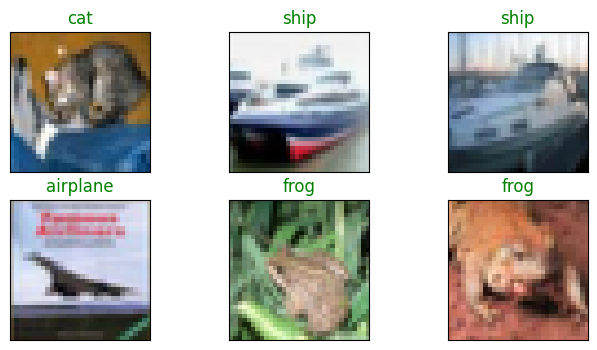

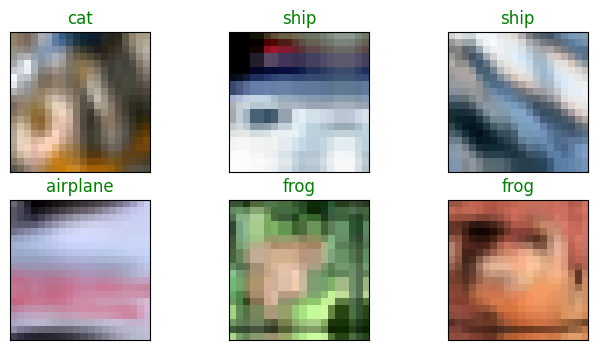

In [20]:
test_DS_wT = copy.deepcopy(test_DS)
test_DS_wT.transform = transform_train
test_DL_wT = torch.utils.data.DataLoader(test_DS_wT, batch_size = BATCH_SIZE, shuffle = False)

im_plot(test_DL)
im_plot(test_DL_wT)

In [13]:
print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

4000
1000
8000


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
torch.Size([32, 3, 32, 32])
cat


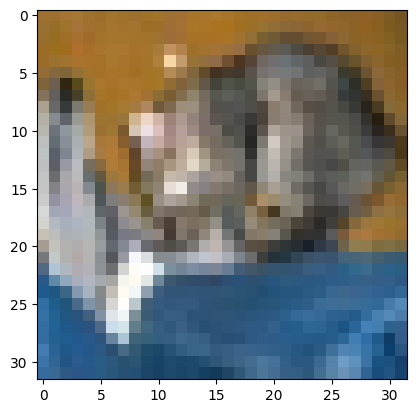

In [26]:
print(test_DS.classes)
print(test_DS.class_to_idx)
x_batch, y_batch = next(iter(test_DL))
print(x_batch.shape)
plt.imshow(x_batch[0].permute(1,2,0))
print(test_DS.classes[y_batch[0]])

In [ ]:
# 1. change to tensor
# 2. change to "numxchannelxrowxcolumn"
# 3, change into 0 to 1 (int -> float)
print(type(train_DS.data))
print(train_DS.data.shape)
print(train_DS.data.dtype)
print(train_DS.data[0][0][0][0])
x_batch, y_batch = next(iter(train_DL)) # select one by using next(iter(train_DS))
print(type(x_batch))
print(x_batch.shape)
print(x_batch.dtype)
print(x_batch[0][0][0][0])

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3,8,3,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv2d(8,16,3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        self.maxp = nn.MaxPool2d(2)
        self.fc = nn.Linear(32*4*4,10)

    def forward(self, x):
        x = self.conv1(x) 
        x = self.maxp(x)
        x = self.conv2(x)
        x = self.maxp(x)
        x = self.conv3(x)
        x = self.maxp(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU())
        
        self.maxp = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.classifier = nn.Sequential(
            nn.Linear(128*12*12,512),
            nn.Linear(512,10))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.maxp(x)
        x = self.conv_block2(x)
        x = self.maxp(x)
        x = self.conv_block3(x)
        x = self.maxp(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return x

In [16]:
exec(f'model = {model_type}()')
print(model)

CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1,

Epoch: 1, Train loss: 10.087
------------------------------
Epoch: 2, Train loss: 3.209
------------------------------
Epoch: 3, Train loss: 2.208
------------------------------
Epoch: 4, Train loss: 1.924
------------------------------
Epoch: 5, Train loss: 1.675
------------------------------
Epoch: 6, Train loss: 1.518
------------------------------
Epoch: 7, Train loss: 1.399
------------------------------
Epoch: 8, Train loss: 1.31
------------------------------
Epoch: 9, Train loss: 1.266
------------------------------
Epoch: 10, Train loss: 1.153
------------------------------
Epoch: 11, Train loss: 1.095
------------------------------
Epoch: 12, Train loss: 1.051
------------------------------
Epoch: 13, Train loss: 0.997
------------------------------
Epoch: 14, Train loss: 0.925
------------------------------
Epoch: 15, Train loss: 0.895
------------------------------


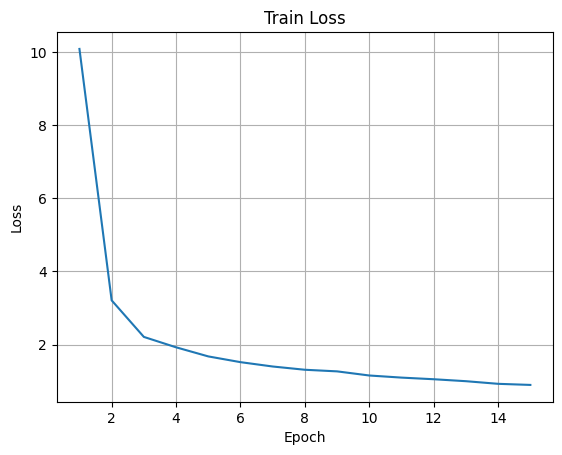

In [17]:
if new_model_train:
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer, EPOCH)

    torch.save(model, save_model_path)

    plt.plot(range(1, EPOCH+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.grid()

In [18]:
load_model = torch.load(save_model_path)

In [19]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 53.012499999999996/8000 (53.01) %
9915626


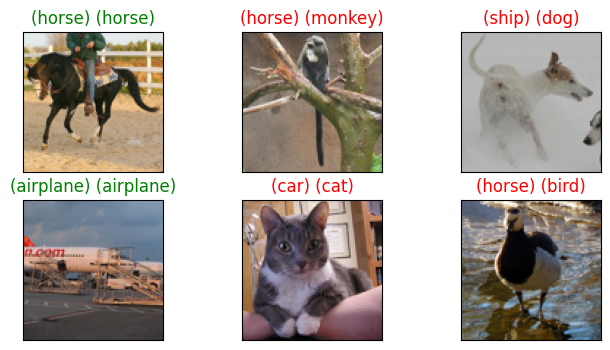

In [20]:
Test_plot(load_model, test_DL)